<a href="https://www.kaggle.com/code/serdargundogdu/forecasting-bus-demand-with-time-series?scriptVersionId=118812149" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Business Problem

The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you. 
The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values):
* **MUNICIPALITY_ID** : where municipality_id is an anonymization to disguise the actual names,There are 10 municipalities (ids from 0 to 9),
* **TIMESTAMP** : timestamp represents the exact time of the measurement,
* **USAGE** :  usage is the number of buses in use at the time of measurement
* **TOTAL_CAPACITY** : total_capacity represents the total number of buses in the municipality

two measurements for an hour.

The committee asks you to forecast the hourly bus usages for next week for each municipality. Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. The bare minimum requirement of the task is one simple baseline and one complex method.)

The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately.

Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import datetime
import itertools
import lightgbm as lgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

from statsmodels.tsa.holtwinters  import SimpleExpSmoothing
from statsmodels.tsa.holtwinters  import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Reading Data

In [2]:
df = pd.read_csv("/kaggle/input/municipality-bus-utilization/municipality_bus_utilization.csv", parse_dates=['timestamp'])

In [3]:
df.head(20)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
5,2017-06-04 07:59:42,5,70,587
6,2017-06-04 07:59:42,2,273,697
7,2017-06-04 07:59:42,1,129,397
8,2017-06-04 07:59:42,6,597,3113
9,2017-06-04 07:59:42,3,623,1930


In [4]:
df.shape

(13070, 4)

# Exploratory Data Analysis (EDA)

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
df["timestamp"].min(), df["timestamp"].max()

(Timestamp('2017-06-04 07:59:42'), Timestamp('2017-08-19 16:30:35'))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB


In [8]:
check_df(df)

##################### Shape #####################
(13070, 4)
##################### Types #####################
timestamp          datetime64[ns]
municipality_id             int64
usage                       int64
total_capacity              int64
dtype: object
##################### Head #####################
            timestamp  municipality_id  usage  total_capacity
0 2017-06-04 07:59:42                9    454            1332
1 2017-06-04 07:59:42                8    556            2947
2 2017-06-04 07:59:42                4   1090            3893
3 2017-06-04 07:59:42                0    204            2813
4 2017-06-04 07:59:42                7    718            2019
##################### Tail #####################
                timestamp  municipality_id  usage  total_capacity
13065 2017-08-19 16:30:35                2    548             697
13066 2017-08-19 16:30:35                8   1193            2947
13067 2017-08-19 16:30:35                7   1354            2019
13068

In [9]:
df['municipality_id'].value_counts()

9    1307
8    1307
4    1307
0    1307
7    1307
5    1307
2    1307
1    1307
6    1307
3    1307
Name: municipality_id, dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
municipality_id,13070.0,4.500000,2.872391,0.0,2.0,4.5,7.0,9.0
usage,13070.0,876.002984,679.287109,11.0,403.0,692.0,1190.0,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,697.0,1974.5,2947.0,3893.0


# Data Visualisation

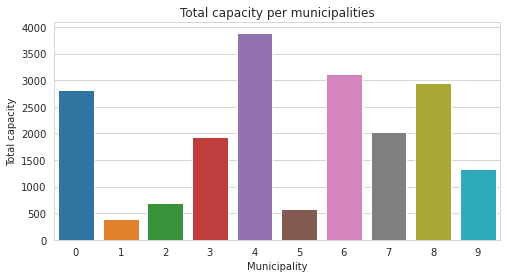

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize = (8, 4))
sns.barplot(x = df["municipality_id"], y = df["total_capacity"])
plt.xlabel('Municipality')
plt.ylabel('Total capacity')
plt.title('Total capacity per municipalities')
plt.show()

In [12]:
print("-"* 50)
capacities = df[["municipality_id", "total_capacity"]].drop_duplicates().sort_values("municipality_id")
for i in capacities.iterrows():
    print("Total capacity of the municipality {} = {} ~ {}%".format(
        i[1]["municipality_id"], i[1]["total_capacity"], round((i[1]["total_capacity"]*100)/sum(capacities["total_capacity"]), 2)))
   # print(i, type(i))
print("-"*50)
print("total capacity:", sum(capacities["total_capacity"]))

--------------------------------------------------
Total capacity of the municipality 0 = 2813 ~ 14.26%
Total capacity of the municipality 1 = 397 ~ 2.01%
Total capacity of the municipality 2 = 697 ~ 3.53%
Total capacity of the municipality 3 = 1930 ~ 9.78%
Total capacity of the municipality 4 = 3893 ~ 19.73%
Total capacity of the municipality 5 = 587 ~ 2.98%
Total capacity of the municipality 6 = 3113 ~ 15.78%
Total capacity of the municipality 7 = 2019 ~ 10.23%
Total capacity of the municipality 8 = 2947 ~ 14.94%
Total capacity of the municipality 9 = 1332 ~ 6.75%
--------------------------------------------------
total capacity: 19728


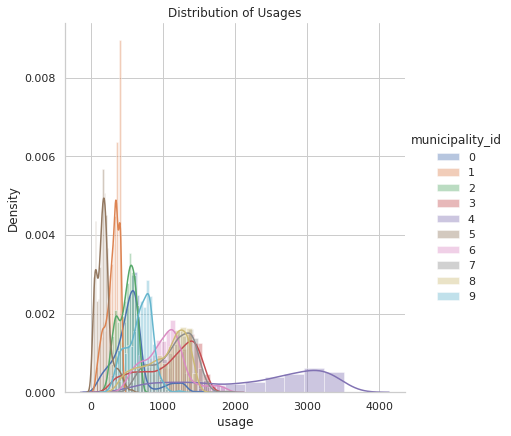

In [13]:
sns.set(style = 'whitegrid')
sns.FacetGrid(df, hue = 'municipality_id', height=6).map(sns.distplot, 'usage').add_legend()
plt.title('Distribution of Usages')
plt.show()

municipality_id = 6 was chosen because it seems to close to normal distribution. Rest of the analysis has been done on 6'th municipality_id.

In [14]:
df6 = df[df.municipality_id == 6]
df6.head()

,timestamp,municipality_id,usage,total_capacity
8,2017-06-04 07:59:42,6,597,3113
12,2017-06-04 08:25:42,6,687,3113
28,2017-06-04 08:59:42,6,801,3113
32,2017-06-04 09:32:46,6,941,3113
49,2017-06-04 09:59:48,6,1061,3113


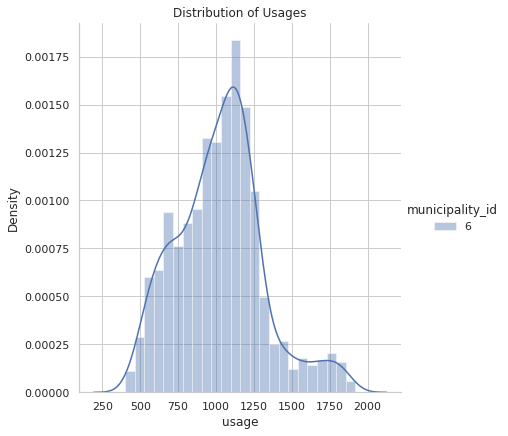

In [15]:
sns.set(style = 'whitegrid')
sns.FacetGrid(df6, hue = 'municipality_id', height=6).map(sns.distplot, 'usage').add_legend()
plt.title('Distribution of Usages')
plt.show()

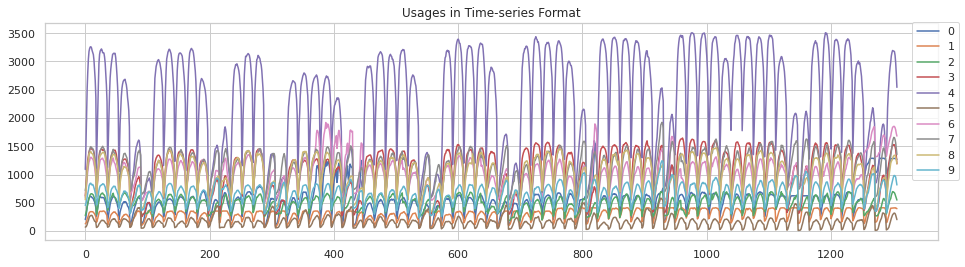

In [16]:
plt.figure(figsize = (16, 4))
for i in range(10):
    plt.plot(df[df['municipality_id'] == i][['usage']].reset_index(drop=True), label=i)
plt.legend(loc='lower right',bbox_to_anchor=(1.03, 0.25))
plt.title('Usages in Time-series Format')
plt.show()

All of municipality usages is stationary. There is no trend or seasonality.

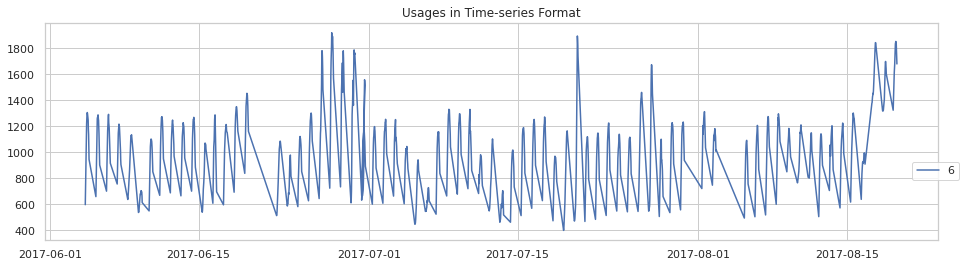

In [17]:
plt.figure(figsize = (16, 4))
plt.plot(df6[["timestamp"]], df6[['usage']].reset_index(drop=True), label=6)
plt.legend(loc='lower right',bbox_to_anchor=(1.03, 0.25))
plt.title('Usages in Time-series Format')
plt.show()

# Data Pre-processing

# Feature Engineering - Feature Extraction

In [18]:
def create_date_features(df):
    df['hour'] = df.timestamp.dt.hour
    df['month'] = df.timestamp.dt.month
    df['day_of_month'] = df.timestamp.dt.day
    df['day_of_year'] = df.timestamp.dt.dayofyear
    df['week_of_year'] = df.timestamp.dt.weekofyear
    df['day_of_week'] = df.timestamp.dt.dayofweek
    df['year'] = df.timestamp.dt.year
    df["is_wknd"] = df.timestamp.dt.weekday // 4
    df['is_month_start'] = df.timestamp.dt.is_month_start.astype(int)
    df['is_month_end'] = df.timestamp.dt.is_month_end.astype(int)
    return df

In [19]:
df = create_date_features(df)

# Missing Values

In [20]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
hour               0
month              0
day_of_month       0
day_of_year        0
week_of_year       0
day_of_week        0
year               0
is_wknd            0
is_month_start     0
is_month_end       0
dtype: int64

# Filling Missing Hours

In [21]:
df.groupby(["municipality_id","hour"]).agg({"usage": ["count", "max"]})

usage      
                     count   max
municipality_id hour            
0               7       26  1009
                8      145  1041
                9      149  1160
                10     141  1198
                11     146  1278
                12     142  1287
                13     152  1286
                14     145  1349
                15     145  1543
                16     116  1494
1               7       26   230
                8      145   295
                9      149   363
                10     141   407
                11     146   411
                12     142   412
                13     152   412
                14     145   412
                15     145   412
                16     116   412
2               7       26   455
                8      145   521
                9      149   614
                10     141   662
                11     146   696
                12     142   696
                13     152   697
                14     145   696
                15     145   690
                16     116   669
3               7       26   655
                8      145   985
                9      149  1375
                10     141  1511
                11     146  1604
                12     142  1625
                13     152  1631
                14     145  1646
                15     145  1558
                16     116  1436
4               7       26  1775
                8      145  2479
                9      149  3052
                10     141  3393
                11     146  3502
                12     142  3508
                13     152  3505
                14     145  3490
                15     145  3316
                16     116  3018
5               7       26    70
                8      145    89
                9      149   159
                10     141   292
                11     146   379
                12     142   437
                13     152   517
                14     145   582
                15     145   576
                16     116   552
6               7       26  1378
                8      145  1383
                9      149  1553
                10     141  1703
                11     146  1823
                12     142  1920
                13     152  1894
                14     145  1884
                15     145  1895
                16     116  1843
7               7       26   821
                8      145  1073
                9      149  1293
                10     141  1428
                11     146  1541
                12     142  1579
                13     152  1634
                14     145  1876
                15     145  1923
                16     116  1895
8               7       26   637
                8      145  1004
                9      149  1280
                10     141  1437
                11     146  1458
                12     142  1459
                13     152  1476
                14     145  1463
                15     145  1386
                16     116  1253
9               7       26   476
                8      145   561
                9      149   720
                10     141   836
                11     146   897
                12     142   978
                13     152  1053
                14     145  1189
                15     145  1244
                16     116  1235

All of municipalities have same sampling count and missing value patterns are same. It does not need to impute missing values.

In [22]:
df.groupby(["week_of_year","municipality_id",]).agg({"usage": ["count", "max"]})

usage      
                             count   max
week_of_year municipality_id            
22           0                  18   614
             1                  18   343
             2                  18   660
             3                  18  1469
             4                  18  3260
             5                  18   278
             6                  18  1306
             7                  18  1493
             8                  18  1406
             9                  18   845
23           0                 126   614
             1                 126   354
             2                 126   676
             3                 126  1455
             4                 126  3222
             5                 126   415
             6                 126  1292
             7                 126  1499
             8                 126  1427
             9                 126   841
24           0                 126   712
             1                 126   354
             2                 126   651
             3                 126  1437
             4                 126  3231
             5                 126   451
             6                 126  1351
             7                 126  1458
             8                 126  1418
             9                 126   936
25           0                  90   793
             1                  90   355
             2                  90   656
             3                  90  1448
             4                  90  3107
             5                  90   439
             6                  90  1454
             7                  90  1458
             8                  90  1409
             9                  90   866
26           0                 141  1261
             1                 141   354
             2                 141   666
             3                 141  1452
             4                 141  3173
             5                 141   426
             6                 141  1920
             7                 141  1507
             8                 141  1403
             9                 141   914
27           0                 126   638
             1                 126   354
             2                 126   687
             3                 126  1530
             4                 126  3396
             5                 126   399
             6                 126  1331
             7                 126  1497
             8                 126  1382
             9                 126   823
28           0                 126   654
             1                 126   354
             2                 126   668
             3                 126  1570
             4                 126  3438
             5                 126   458
             6                 126  1330
             7                 126  1511
             8                 126  1416
             9                 126   898
29           0                 125  1543
             1                 125   411
             2                 125   656
             3                 125  1566
             4                 125  3427
             5                 125   501
             6                 125  1895
             7                 125  1587
             8                 125  1453
             9                 125  1032
30           0                 125  1163
             1                 125   412
             2                 125   696
             3                 125  1646
             4                 125  3507
             5                 125   582
             6                 125  1674
             7                 125  1923
             8                 125  1407
             9                 125  1244
31           0                  72   669
             1                  72   411
             2                  72   696
             3                  72  1595
             4                  72  3461
           

In [23]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2017-06-04 07:59:42,9,454,1332,7,6,4,155,22,6,2017,1,0,0
1,2017-06-04 07:59:42,8,556,2947,7,6,4,155,22,6,2017,1,0,0
2,2017-06-04 07:59:42,4,1090,3893,7,6,4,155,22,6,2017,1,0,0
3,2017-06-04 07:59:42,0,204,2813,7,6,4,155,22,6,2017,1,0,0
4,2017-06-04 07:59:42,7,718,2019,7,6,4,155,22,6,2017,1,0,0


# Resampling data in Hourly basis

In [24]:
df_resampled = pd.DataFrame()

In [25]:
df["timestamp"] = df["timestamp"].astype(str).apply(lambda x: x[:-6]).astype("datetime64")
df_resampled = df.groupby(["timestamp","municipality_id"]).agg({"usage": "max"}).reset_index()
df_resampled.drop_duplicates(["timestamp","municipality_id"],inplace=True)

In [26]:
df_resampled.head()

,timestamp,municipality_id,usage
0,2017-06-04 07:00:00,0,204
1,2017-06-04 07:00:00,1,129
2,2017-06-04 07:00:00,2,273
3,2017-06-04 07:00:00,3,623
4,2017-06-04 07:00:00,4,1090


In [27]:
dfs={}
for i in range(10):
    dfs[i]= pd.DataFrame(data=df_resampled[df_resampled.municipality_id==i], columns=["timestamp","usage"]).set_index("timestamp")

In [28]:
dfs[6].shape

(674, 1)

In [29]:
type(dfs[6])

pandas.core.frame.DataFrame

# Train and Test Split

In [30]:
trains={}
tests={}
for i in range(10):
    trains[i] = dfs[i][:"2017-08-04 16:00:00"]
    tests[i] = dfs[i]["2017-08-05 07:00:00":]
    print (f"train {i} size:  ", len(trains[i]))
    print (f"test {i} size: ", len(tests[i]))

train 0 size:   532
test 0 size:  142
train 1 size:   532
test 1 size:  142
train 2 size:   532
test 2 size:  142
train 3 size:   532
test 3 size:  142
train 4 size:   532
test 4 size:  142
train 5 size:   532
test 5 size:  142
train 6 size:   532
test 6 size:  142
train 7 size:   532
test 7 size:  142
train 8 size:   532
test 8 size:  142
train 9 size:   532
test 9 size:  142


In [31]:
trains[6].head()

,usage
timestamp,
2017-06-04 07:00:00,597
2017-06-04 08:00:00,801
2017-06-04 09:00:00,1061
2017-06-04 10:00:00,1219
2017-06-04 11:00:00,1297


In [32]:
tests[6].head()

,usage
timestamp,
2017-08-05 08:00:00,571
2017-08-05 09:00:00,755
2017-08-05 10:00:00,903
2017-08-05 11:00:00,1057
2017-08-05 12:00:00,1082


# Single Exponential Smoothing

In [33]:
def ses_optimizer(train,test, alphas, step=142):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [34]:
alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(trains[6],tests[6], alphas, step=142)

alpha: 0.01 mae: 238.8389
alpha: 0.11 mae: 228.1232
alpha: 0.21 mae: 228.3075
alpha: 0.31 mae: 228.5778
alpha: 0.41 mae: 229.179
alpha: 0.51 mae: 230.1953
alpha: 0.61 mae: 231.7417
alpha: 0.71 mae: 233.4257
alpha: 0.81 mae: 235.0251
alpha: 0.91 mae: 236.3511
best_alpha: 0.11 best_mae: 228.1232


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

In [35]:
ses_model = SimpleExpSmoothing(trains[6]).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(142)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [36]:
tests[6].head()

,usage
timestamp,
2017-08-05 08:00:00,571
2017-08-05 09:00:00,755
2017-08-05 10:00:00,903
2017-08-05 11:00:00,1057
2017-08-05 12:00:00,1082


In [37]:
y_pred.reset_index(drop=True,inplace=True)
y_pred=pd.DataFrame(y_pred, columns=["usage"])
y_pred = y_pred.merge(tests[6].reset_index()["timestamp"], left_index=True, right_index=True).set_index("timestamp")

In [38]:
y_pred["usage"].head()

timestamp
2017-08-05 08:00:00    1083.751736
2017-08-05 09:00:00    1083.751736
2017-08-05 10:00:00    1083.751736
2017-08-05 11:00:00    1083.751736
2017-08-05 12:00:00    1083.751736
Name: usage, dtype: float64

In [39]:
y_pred.index

DatetimeIndex(['2017-08-05 08:00:00', '2017-08-05 09:00:00', '2017-08-05 10:00:00', '2017-08-05 11:00:00', '2017-08-05 12:00:00', '2017-08-05 13:00:00', '2017-08-05 14:00:00', '2017-08-05 15:00:00', '2017-08-05 16:00:00', '2017-08-06 07:00:00',
               ...
               '2017-08-18 16:00:00', '2017-08-19 08:00:00', '2017-08-19 09:00:00', '2017-08-19 10:00:00', '2017-08-19 11:00:00', '2017-08-19 12:00:00', '2017-08-19 13:00:00', '2017-08-19 14:00:00', '2017-08-19 15:00:00', '2017-08-19 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=142, freq=None)

In [40]:
trains[6]["usage"].head()

timestamp
2017-06-04 07:00:00     597
2017-06-04 08:00:00     801
2017-06-04 09:00:00    1061
2017-06-04 10:00:00    1219
2017-06-04 11:00:00    1297
Name: usage, dtype: int64

In [41]:
trains[6]["usage"].index

DatetimeIndex(['2017-06-04 07:00:00', '2017-06-04 08:00:00', '2017-06-04 09:00:00', '2017-06-04 10:00:00', '2017-06-04 11:00:00', '2017-06-04 12:00:00', '2017-06-04 13:00:00', '2017-06-04 14:00:00', '2017-06-04 15:00:00', '2017-06-04 16:00:00',
               ...
               '2017-08-02 07:00:00', '2017-08-02 08:00:00', '2017-08-02 09:00:00', '2017-08-02 10:00:00', '2017-08-02 11:00:00', '2017-08-02 12:00:00', '2017-08-02 13:00:00', '2017-08-02 14:00:00', '2017-08-02 15:00:00', '2017-08-02 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=532, freq=None)

In [42]:
tests[6]["usage"].head()

timestamp
2017-08-05 08:00:00     571
2017-08-05 09:00:00     755
2017-08-05 10:00:00     903
2017-08-05 11:00:00    1057
2017-08-05 12:00:00    1082
Name: usage, dtype: int64

In [43]:
tests[6]["usage"].index

DatetimeIndex(['2017-08-05 08:00:00', '2017-08-05 09:00:00', '2017-08-05 10:00:00', '2017-08-05 11:00:00', '2017-08-05 12:00:00', '2017-08-05 13:00:00', '2017-08-05 14:00:00', '2017-08-05 15:00:00', '2017-08-05 16:00:00', '2017-08-06 07:00:00',
               ...
               '2017-08-18 16:00:00', '2017-08-19 08:00:00', '2017-08-19 09:00:00', '2017-08-19 10:00:00', '2017-08-19 11:00:00', '2017-08-19 12:00:00', '2017-08-19 13:00:00', '2017-08-19 14:00:00', '2017-08-19 15:00:00', '2017-08-19 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=142, freq=None)

In [44]:
def plot_prediction(i,y_pred, label):
    plt.figure(figsize=(16, 4))
    trains[i]["usage"].plot(legend=True, label=f"TRAIN {i}")
    tests[i]["usage"].plot(legend=True, label=f"TEST {i}")
    y_pred["usage"].plot(legend=True, label=f"PREDICTION {i}")
    plt.xlim([datetime.date(2017,6,4), datetime.date(2017,8,20)])
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

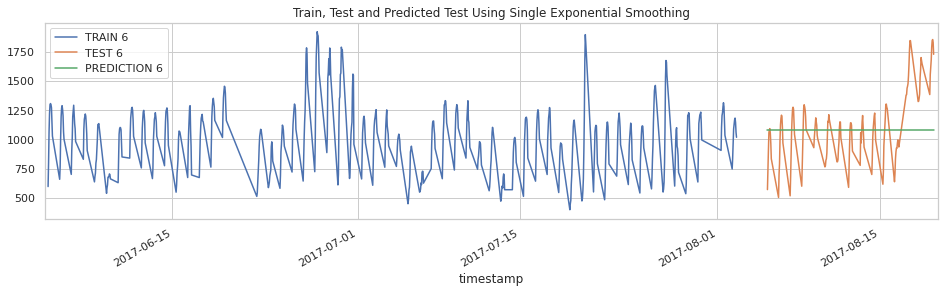

In [45]:
plot_prediction(6, y_pred, "Single Exponential Smoothing")

# Double Exponential Smoothing

In [46]:
def des_optimizer(train,test, alphas, betas, step=142):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [47]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(trains[6],tests[6], alphas, betas, step=142)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

alpha: 0.01 beta: 0.01 mae: 249.3288
alpha: 0.01 beta: 0.11 mae: 219.397
alpha: 0.01 beta: 0.21 mae: 252.0579
alpha: 0.01 beta: 0.31 mae: 614.2133
alpha: 0.01 beta: 0.41 mae: 370.7218
alpha: 0.01 beta: 0.51 mae: 1419.3573
alpha: 0.01 beta: 0.61 mae: 1031.427
alpha: 0.01 beta: 0.71 mae: 1894.4656
alpha: 0.01 beta: 0.81 mae: 1233.1555
alpha: 0.01 beta: 0.91 mae: 357.9642
alpha: 0.11 beta: 0.01 mae: 220.3818
alpha: 0.11 beta: 0.11 mae: 234.3449
alpha: 0.11 beta: 0.21 mae: 788.8281


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

alpha: 0.11 beta: 0.31 mae: 1177.9012
alpha: 0.11 beta: 0.41 mae: 369.4635
alpha: 0.11 beta: 0.51 mae: 764.0005
alpha: 0.11 beta: 0.61 mae: 1242.0818
alpha: 0.11 beta: 0.71 mae: 1151.9381
alpha: 0.11 beta: 0.81 mae: 891.304
alpha: 0.11 beta: 0.91 mae: 1233.3061
alpha: 0.21 beta: 0.01 mae: 219.833
alpha: 0.21 beta: 0.11 mae: 310.6273
alpha: 0.21 beta: 0.21 mae: 298.6453
alpha: 0.21 beta: 0.31 mae: 419.7717
alpha: 0.21 beta: 0.41 mae: 1001.1839
alpha: 0.21 beta: 0.51 mae: 1676.2612


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

alpha: 0.21 beta: 0.61 mae: 2444.0351
alpha: 0.21 beta: 0.71 mae: 2825.7177
alpha: 0.21 beta: 0.81 mae: 2486.0332
alpha: 0.21 beta: 0.91 mae: 1596.953
alpha: 0.31 beta: 0.01 mae: 219.9286
alpha: 0.31 beta: 0.11 mae: 265.9684
alpha: 0.31 beta: 0.21 mae: 221.0489
alpha: 0.31 beta: 0.31 mae: 553.8024
alpha: 0.31 beta: 0.41 mae: 854.5863
alpha: 0.31 beta: 0.51 mae: 709.1978
alpha: 0.31 beta: 0.61 mae: 251.016
alpha: 0.31 beta: 0.71 mae: 1398.1317
alpha: 0.31 beta: 0.81 mae: 3136.3045
alpha: 0.31 beta: 0.91 mae: 5298.949


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

alpha: 0.41 beta: 0.01 mae: 220.2851
alpha: 0.41 beta: 0.11 mae: 278.4336
alpha: 0.41 beta: 0.21 mae: 234.4655
alpha: 0.41 beta: 0.31 mae: 230.6986
alpha: 0.41 beta: 0.41 mae: 551.8432
alpha: 0.41 beta: 0.51 mae: 1597.2326
alpha: 0.41 beta: 0.61 mae: 3163.9246
alpha: 0.41 beta: 0.71 mae: 5017.3311
alpha: 0.41 beta: 0.81 mae: 6844.5047
alpha: 0.41 beta: 0.91 mae: 8298.4652
alpha: 0.51 beta: 0.01 mae: 221.3479
alpha: 0.51 beta: 0.11 mae: 346.3047
alpha: 0.51 beta: 0.21 mae: 458.111


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

alpha: 0.51 beta: 0.31 mae: 854.4823
alpha: 0.51 beta: 0.41 mae: 1781.4336
alpha: 0.51 beta: 0.51 mae: 3138.0696
alpha: 0.51 beta: 0.61 mae: 4619.7341
alpha: 0.51 beta: 0.71 mae: 5890.2327
alpha: 0.51 beta: 0.81 mae: 6705.1176
alpha: 0.51 beta: 0.91 mae: 6995.3047
alpha: 0.61 beta: 0.01 mae: 224.0152
alpha: 0.61 beta: 0.11 mae: 444.8669
alpha: 0.61 beta: 0.21 mae: 778.6011
alpha: 0.61 beta: 0.31 mae: 1436.2513
alpha: 0.61 beta: 0.41 mae: 2493.5319
alpha: 0.61 beta: 0.51 mae: 3698.911
alpha: 0.61 beta: 0.61 mae: 4738.7704


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

alpha: 0.61 beta: 0.71 mae: 5409.8498
alpha: 0.61 beta: 0.81 mae: 5676.8442
alpha: 0.61 beta: 0.91 mae: 5629.7857
alpha: 0.71 beta: 0.01 mae: 227.2771
alpha: 0.71 beta: 0.11 mae: 546.9036
alpha: 0.71 beta: 0.21 mae: 1023.3507
alpha: 0.71 beta: 0.31 mae: 1781.0359
alpha: 0.71 beta: 0.41 mae: 2776.6398
alpha: 0.71 beta: 0.51 mae: 3736.1358
alpha: 0.71 beta: 0.61 mae: 4441.9197
alpha: 0.71 beta: 0.71 mae: 4825.8589
alpha: 0.71 beta: 0.81 mae: 4944.618
alpha: 0.71 beta: 0.91 mae: 4904.6063


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

alpha: 0.81 beta: 0.01 mae: 230.4185
alpha: 0.81 beta: 0.11 mae: 626.8851
alpha: 0.81 beta: 0.21 mae: 1181.7654
alpha: 0.81 beta: 0.31 mae: 1949.9634
alpha: 0.81 beta: 0.41 mae: 2832.736
alpha: 0.81 beta: 0.51 mae: 3596.2232
alpha: 0.81 beta: 0.61 mae: 4109.9191
alpha: 0.81 beta: 0.71 mae: 4370.979
alpha: 0.81 beta: 0.81 mae: 4445.0487
alpha: 0.81 beta: 0.91 mae: 4403.1089
alpha: 0.91 beta: 0.01 mae: 233.0339
alpha: 0.91 beta: 0.11 mae: 682.8492
alpha: 0.91 beta: 0.21 mae: 1272.565
alpha: 0.91 beta: 0.31 mae: 2009.6361
alpha: 0.91 beta: 0.41 mae: 2780.3409
alpha: 0.91 beta: 0.51 mae: 3398.2669
alpha: 0.91 beta: 0.61 mae: 3783.9679
alpha: 0.91 beta: 0.71 mae: 3953.4253
alpha: 0.91 beta: 0.81 mae: 3956.512
alpha: 0.91 beta: 0.91 mae: 3837.7432
best_alpha: 0.01 best_beta: 0.11 best_mae: 219.397


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

In [48]:
des_model = ExponentialSmoothing(trains[6], trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(142)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [49]:
y_pred.reset_index(drop=True,inplace=True)
y_pred=pd.DataFrame(y_pred, columns=["usage"])
y_pred = y_pred.merge(tests[6].reset_index()["timestamp"], left_index=True, right_index=True).set_index("timestamp")

In [50]:
y_pred["usage"].head()

timestamp
2017-08-05 08:00:00    1017.474196
2017-08-05 09:00:00    1018.370075
2017-08-05 10:00:00    1019.265954
2017-08-05 11:00:00    1020.161833
2017-08-05 12:00:00    1021.057712
Name: usage, dtype: float64

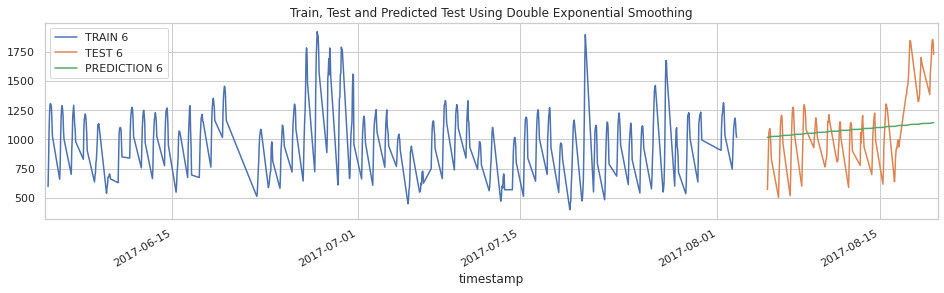

In [51]:
plot_prediction(6, y_pred, "Double Exponential Smoothing")

# Triple Exponential Smoothing

In [52]:
def tes_optimizer(train,test, abg, step=142):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=10).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [53]:
alphas = betas = gammas = np.arange(0.01, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(trains[6], tests[6], abg, step=142)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.01, 0.01, 0.01, 244.92]
[0.01, 0.01, 0.21, 233.5]
[0.01, 0.01, 0.41, 235.27]
[0.01, 0.01, 0.61, 238.88]
[0.01, 0.01, 0.81, 241.84]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.01, 0.21, 0.01, 244.12]
[0.01, 0.21, 0.21, 228.38]
[0.01, 0.21, 0.41, 228.78]
[0.01, 0.21, 0.61, 229.21]
[0.01, 0.21, 0.81, 231.59]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.01, 0.41, 0.01, 341.45]
[0.01, 0.41, 0.21, 229.13]
[0.01, 0.41, 0.41, 230.33]
[0.01, 0.41, 0.61, 235.34]
[0.01, 0.41, 0.81, 254.94]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.01, 0.61, 0.01, 1033.37]
[0.01, 0.61, 0.21, 343.81]
[0.01, 0.61, 0.41, 233.12]
[0.01, 0.61, 0.61, 255.46]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.01, 0.61, 0.81, 316.94]
[0.01, 0.81, 0.01, 1187.83]
[0.01, 0.81, 0.21, 241.83]
[0.01, 0.81, 0.41, 242.42]
[0.01, 0.81, 0.61, 310.6]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.01, 0.81, 0.81, 440.02]
[0.21, 0.01, 0.01, 222.18]
[0.21, 0.01, 0.21, 222.78]
[0.21, 0.01, 0.41, 222.62]
[0.21, 0.01, 0.61, 231.15]
[0.21, 0.01, 0.81, 232.58]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.21, 0.21, 0.01, 216.56]
[0.21, 0.21, 0.21, 327.77]
[0.21, 0.21, 0.41, 314.57]
[0.21, 0.21, 0.61, 337.13]
[0.21, 0.21, 0.81, 298.81]
[0.21, 0.41, 0.01, 1516.91]
[0.21, 0.41, 0.21, 1005.03]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.21, 0.41, 0.41, 814.79]
[0.21, 0.41, 0.61, 238.07]
[0.21, 0.41, 0.81, 2987.6]
[0.21, 0.61, 0.01, 3284.51]
[0.21, 0.61, 0.21, 2671.76]
[0.21, 0.61, 0.41, 395.22]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.21, 0.61, 0.61, 20064.69]
[0.21, 0.61, 0.81, 6383.09]
[0.21, 0.81, 0.01, 3654.31]
[0.21, 0.81, 0.21, 3384.32]
[0.21, 0.81, 0.41, 605.84]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has n

[0.21, 0.81, 0.61, 7115.28]
[0.21, 0.81, 0.81, 4.243966890014792e+24]
[0.41, 0.01, 0.01, 221.28]
[0.41, 0.01, 0.21, 226.33]
[0.41, 0.01, 0.41, 220.99]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.41, 0.01, 0.61, 228.14]
[0.41, 0.01, 0.81, 242.8]
[0.41, 0.21, 0.01, 370.52]
[0.41, 0.21, 0.21, 298.13]
[0.41, 0.21, 0.41, 1498.8]
[0.41, 0.21, 0.61, 431.75]
[0.41, 0.21, 0.81, 663.85]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.41, 0.41, 0.01, 351.68]
[0.41, 0.41, 0.21, 628.77]
[0.41, 0.41, 0.41, 3458.47]
[0.41, 0.41, 0.61, 287.68]
[0.41, 0.41, 0.81, 1108.7]
[0.41, 0.61, 0.01, 2059.12]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.41, 0.61, 0.21, 7864.41]
[0.41, 0.61, 0.41, 6123.49]
[0.41, 0.61, 0.61, 58534315.59]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

[0.41, 0.61, 0.81, 9.600238755030348e+25]
[0.41, 0.81, 0.01, 5921.79]
[0.41, 0.81, 0.21, 9732.66]
[0.41, 0.81, 0.41, 2290671981.46]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimi

[0.41, 0.81, 0.61, 5.493230661551049e+24]
[0.41, 0.81, 0.81, 2.55356708216677e+21]
[0.61, 0.01, 0.01, 219.12]
[0.61, 0.01, 0.21, 269.1]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.61, 0.01, 0.41, 240.98]
[0.61, 0.01, 0.61, 298.74]
[0.61, 0.01, 0.81, 269.67]
[0.61, 0.21, 0.01, 371.31]
[0.61, 0.21, 0.21, 3777.98]
[0.61, 0.21, 0.41, 3372.48]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.61, 0.21, 0.61, 1187.97]
[0.61, 0.21, 0.81, 2796.74]
[0.61, 0.41, 0.01, 1893.5]
[0.61, 0.41, 0.21, 10489.24]
[0.61, 0.41, 0.41, 761.16]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

[0.61, 0.41, 0.61, 48732.13]
[0.61, 0.41, 0.81, 132200612827.06]
[0.61, 0.61, 0.01, 4400.36]
[0.61, 0.61, 0.21, 6589.72]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has n

[0.61, 0.61, 0.41, 2065.93]
[0.61, 0.61, 0.61, 2126.96]
[0.61, 0.61, 0.81, 2.4826031793031155e+23]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwin

[0.61, 0.81, 0.01, 5797.2]
[0.61, 0.81, 0.21, 4113.3]
[0.61, 0.81, 0.41, 2888.05]
[0.61, 0.81, 0.61, 3045127211293.59]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported in

[0.61, 0.81, 0.81, 5.2389397520374645e+25]
[0.81, 0.01, 0.01, 219.77]
[0.81, 0.01, 0.21, 313.91]
[0.81, 0.01, 0.41, 246.16]
[0.81, 0.01, 0.61, 436.24]
[0.81, 0.01, 0.81, 329.79]
[0.81, 0.21, 0.01, 813.28]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.81, 0.21, 0.21, 3667.97]
[0.81, 0.21, 0.41, 1998.68]
[0.81, 0.21, 0.61, 3098.57]
[0.81, 0.21, 0.81, 1981.94]
[0.81, 0.41, 0.01, 2469.01]
[0.81, 0.41, 0.21, 3421.47]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.81, 0.41, 0.41, 2029.3]
[0.81, 0.41, 0.61, 2306.53]
[0.81, 0.41, 0.81, 1297.57]
[0.81, 0.61, 0.01, 3990.71]
[0.81, 0.61, 0.21, 3117.62]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[0.81, 0.61, 0.41, 3664.36]
[0.81, 0.61, 0.61, 1212.05]
[0.81, 0.61, 0.81, 15669902513116.24]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has n

[0.81, 0.81, 0.01, 4470.8]
[0.81, 0.81, 0.21, 2390.58]
[0.81, 0.81, 0.41, 647.52]
[0.81, 0.81, 0.61, 57485245790100.99]
[0.81, 0.81, 0.81, 7.277113713249368e+20]
best_alpha: 0.21 best_beta: 0.21 best_gamma: 0.01 best_mae: 216.5612


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

In [54]:
tes_model = ExponentialSmoothing(trains[6], trend="add", seasonal="add", seasonal_periods=90).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(142)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [55]:
y_pred.head()

532    1130.737229
533    1161.364587
534    1126.737078
535    1014.225935
536    1028.737115
dtype: float64

In [56]:
y_pred.reset_index(drop=True,inplace=True)
y_pred=pd.DataFrame(y_pred, columns=["usage"])
y_pred = y_pred.merge(tests[6].reset_index()["timestamp"], left_index=True, right_index=True).set_index("timestamp")

In [57]:
y_pred["usage"].head()

timestamp
2017-08-05 08:00:00    1130.737229
2017-08-05 09:00:00    1161.364587
2017-08-05 10:00:00    1126.737078
2017-08-05 11:00:00    1014.225935
2017-08-05 12:00:00    1028.737115
Name: usage, dtype: float64

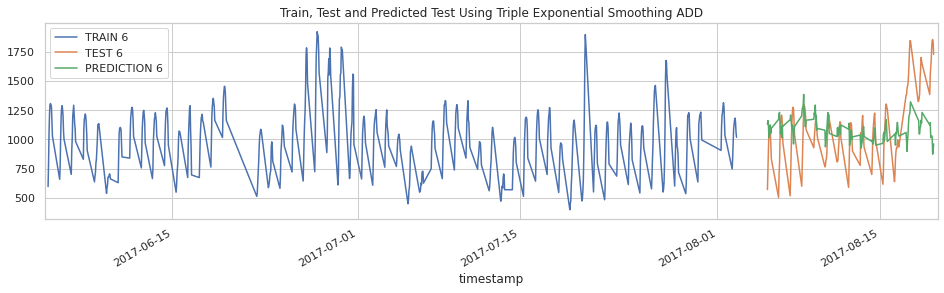

In [58]:
plot_prediction(6, y_pred, "Triple Exponential Smoothing ADD")

# SARIMA

In [59]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

In [60]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}4 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [61]:
best_order, best_seasonal_order = sarima_optimizer_aic(trains[6], pdq, seasonal_pdq)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:8924.330789456793
SARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:8531.326195945616
SARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:7826.451959971306


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:7494.235376770268
SARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:7876.231282168123


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt

SARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:154.13206472089757
SARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:7487.589772193281
SARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:7447.954334702825
SARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:8292.580837330634


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:7924.158725286647
SARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:7380.97421100389


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:7137.445518238046


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:7435.091732661411


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:111.67624985621597


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:7217.4764839821955


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:7136.500721471905
SARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:7096.075091720344
SARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:7067.023584019029
SARIMA(0, 1, 0)x(0, 1, 0, 4)4 - AIC:7519.819893144597


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt

SARIMA(0, 1, 0)x(0, 1, 1, 4)4 - AIC:7066.112228552973
SARIMA(0, 1, 0)x(1, 0, 0, 4)4 - AIC:7068.950310425847


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(1, 0, 1, 4)4 - AIC:7060.033193831323
SARIMA(0, 1, 0)x(1, 1, 0, 4)4 - AIC:7276.684151910628


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(1, 1, 1, 4)4 - AIC:7039.696072309978
SARIMA(0, 1, 1)x(0, 0, 0, 4)4 - AIC:7074.449044069259


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(0, 0, 1, 4)4 - AIC:7060.198077720881
SARIMA(0, 1, 1)x(0, 1, 0, 4)4 - AIC:7452.147679715384


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(0, 1, 1, 4)4 - AIC:7044.339998219615
SARIMA(0, 1, 1)x(1, 0, 0, 4)4 - AIC:7062.234353057513


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 0, 1, 4)4 - AIC:7051.569180769806
SARIMA(0, 1, 1)x(1, 1, 0, 4)4 - AIC:7271.637466935108


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 1, 1, 4)4 - AIC:7032.676096412283
SARIMA(1, 0, 0)x(0, 0, 0, 4)4 - AIC:7110.0627248351975


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(0, 0, 1, 4)4 - AIC:7083.180542273538
SARIMA(1, 0, 0)x(0, 1, 0, 4)4 - AIC:7453.8840984589915


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(0, 1, 1, 4)4 - AIC:7016.887083131518
SARIMA(1, 0, 0)x(1, 0, 0, 4)4 - AIC:7084.609782132813


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(1, 0, 1, 4)4 - AIC:7077.269949566262
SARIMA(1, 0, 0)x(1, 1, 0, 4)4 - AIC:7194.577404429212


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(1, 1, 1, 4)4 - AIC:6997.234677354093
SARIMA(1, 0, 1)x(0, 0, 0, 4)4 - AIC:7086.63996590049


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(0, 0, 1, 4)4 - AIC:7075.100694856236
SARIMA(1, 0, 1)x(0, 1, 0, 4)4 - AIC:7340.858814738761


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(0, 1, 1, 4)4 - AIC:6969.296823542954


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 0, 0, 4)4 - AIC:7076.620424573535


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 0, 1, 4)4 - AIC:7068.157208221871


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 1, 0, 4)4 - AIC:7157.487242184001


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 1, 1, 4)4 - AIC:6966.7790386088
SARIMA(1, 1, 0)x(0, 0, 0, 4)4 - AIC:7077.5099619820485
SARIMA(1, 1, 0)x(0, 0, 1, 4)4 - AIC:7062.698261101879
SARIMA(1, 1, 0)x(0, 1, 0, 4)4 - AIC:7451.144630731446


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt

SARIMA(1, 1, 0)x(0, 1, 1, 4)4 - AIC:7047.36551454322
SARIMA(1, 1, 0)x(1, 0, 0, 4)4 - AIC:7064.752373952591


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 0, 1, 4)4 - AIC:7053.817516015248
SARIMA(1, 1, 0)x(1, 1, 0, 4)4 - AIC:7273.343186223379


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 1, 1, 4)4 - AIC:7035.227395630331
SARIMA(1, 1, 1)x(0, 0, 0, 4)4 - AIC:7076.4435578376315


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(0, 0, 1, 4)4 - AIC:7061.529683126173
SARIMA(1, 1, 1)x(0, 1, 0, 4)4 - AIC:7451.238053736999


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(0, 1, 1, 4)4 - AIC:7046.337249748634


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 0, 0, 4)4 - AIC:7063.519575106398


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 0, 1, 4)4 - AIC:7053.315623814609


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 1, 0, 4)4 - AIC:7229.9131302201695


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 1, 1, 4)4 - AIC:6997.186168815582
SARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:111.67624985621597


In [62]:
model = SARIMAX(trains[6], order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=142)

y_pred = y_pred_test.predicted_mean
mean_absolute_error(tests[6], y_pred)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


4066.893977548663

# Random Noise

In [63]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Laf/Shifted Features

In [64]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2017-06-04 07:00:00,9,454,1332,7,6,4,155,22,6,2017,1,0,0
1,2017-06-04 07:00:00,8,556,2947,7,6,4,155,22,6,2017,1,0,0
2,2017-06-04 07:00:00,4,1090,3893,7,6,4,155,22,6,2017,1,0,0
3,2017-06-04 07:00:00,0,204,2813,7,6,4,155,22,6,2017,1,0,0
4,2017-06-04 07:00:00,7,718,2019,7,6,4,155,22,6,2017,1,0,0


In [65]:
df.sort_values(by=["municipality_id", "total_capacity","timestamp"], axis=0, inplace=True)

In [66]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
3,2017-06-04 07:00:00,0,204,2813,7,6,4,155,22,6,2017,1,0,0
18,2017-06-04 08:00:00,0,247,2813,8,6,4,155,22,6,2017,1,0,0
29,2017-06-04 08:00:00,0,332,2813,8,6,4,155,22,6,2017,1,0,0
34,2017-06-04 09:00:00,0,429,2813,9,6,4,155,22,6,2017,1,0,0
47,2017-06-04 09:00:00,0,485,2813,9,6,4,155,22,6,2017,1,0,0


In [67]:
pd.DataFrame({"usage": df["usage"].values[0:10],
              "lag1": df["usage"].shift(1).values[0:10],
              "lag2": df["usage"].shift(2).values[0:10],
              "lag3": df["usage"].shift(3).values[0:10],
              "lag4": df["usage"].shift(4).values[0:10]})

,usage,lag1,lag2,lag3,lag4
0,204,NaN,NaN,NaN,NaN
1,247,204.0,NaN,NaN,NaN
2,332,247.0,204.0,NaN,NaN
3,429,332.0,247.0,204.0,NaN
4,485,429.0,332.0,247.0,204.0
5,534,485.0,429.0,332.0,247.0
6,583,534.0,485.0,429.0,332.0
7,597,583.0,534.0,485.0,429.0
8,614,597.0,583.0,534.0,485.0
9,613,614.0,597.0,583.0,534.0


In [68]:
df.groupby(["municipality_id","total_capacity"])["usage"].head()

3      204
18     247
29     332
34     429
47     485
7      129
19     138
24     164
36     213
46     245
6      273
10     311
23     355
37     423
41     494
9      623
17     770
22     967
39    1130
45    1263
2     1090
14    1476
26    2016
33    2511
43    2811
5       70
16      73
20      89
35     116
40     159
8      597
12     687
28     801
32     941
49    1061
4      718
13     789
27     873
38    1013
44    1151
1      556
15     674
25     857
30    1045
42    1172
0      454
11     487
21     527
31     599
48     666
Name: usage, dtype: int64

In [69]:
df.groupby(["municipality_id","total_capacity"])["usage"].transform(lambda x: x.shift(1))

3           NaN
18        204.0
29        247.0
34        332.0
47        429.0
55        485.0
65        534.0
71        583.0
88        597.0
95        614.0
105       613.0
115       605.0
126       590.0
136       585.0
140       569.0
152       538.0
160       520.0
172       470.0
189       415.0
198       255.0
205       335.0
213       428.0
228       487.0
238       556.0
243       595.0
254       612.0
266       602.0
274       591.0
285       589.0
291       595.0
302       592.0
315       588.0
326       556.0
331       530.0
344       491.0
354       454.0
360       399.0
373       183.0
387       258.0
395       333.0
406       398.0
414       470.0
423       521.0
433       549.0
441       578.0
453       601.0
460       609.0
474       614.0
481       601.0
499       590.0
509       550.0
516       518.0
525       499.0
539       443.0
548       406.0
556       198.0
563       259.0
578       335.0
581       381.0
593       413.0
607       456.0
612       486.0
621     

In [70]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['usage_lag_' + str(lag)] = dataframe.groupby(["municipality_id", "total_capacity"])['usage'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [71]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [72]:
check_df(df)

##################### Shape #####################
(13070, 24)
##################### Types #####################
timestamp          datetime64[ns]
municipality_id             int64
usage                       int64
total_capacity              int64
hour                        int64
month                       int64
day_of_month                int64
day_of_year                 int64
week_of_year                int64
day_of_week                 int64
year                        int64
is_wknd                     int64
is_month_start              int64
is_month_end                int64
usage_lag_91              float64
usage_lag_98              float64
usage_lag_105             float64
usage_lag_112             float64
usage_lag_119             float64
usage_lag_126             float64
usage_lag_182             float64
usage_lag_364             float64
usage_lag_546             float64
usage_lag_728             float64
dtype: object
##################### Head #####################
         

# Rolling Mean Features

In [73]:
pd.DataFrame({"usage": df["usage"].values[0:10],
              "roll2": df["usage"].rolling(window=2).mean().values[0:10],
              "roll3": df["usage"].rolling(window=3).mean().values[0:10],
              "roll5": df["usage"].rolling(window=5).mean().values[0:10]})

pd.DataFrame({"usage": df["usage"].values[0:10],
              "roll2": df["usage"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["usage"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["usage"].shift(1).rolling(window=5).mean().values[0:10]})

,usage,roll2,roll3,roll5
0,204,NaN,NaN,NaN
1,247,NaN,NaN,NaN
2,332,225.5,NaN,NaN
3,429,289.5,261.000000,NaN
4,485,380.5,336.000000,NaN
5,534,457.0,415.333333,339.4
6,583,509.5,482.666667,405.4
7,597,558.5,534.000000,472.6
8,614,590.0,571.333333,525.6
9,613,605.5,598.000000,562.6


In [74]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['usage_roll_mean_' + str(window)] = dataframe.groupby(["municipality_id", "total_capacity"])['usage']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [75]:
df = roll_mean_features(df, [365, 546])

In [76]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,usage_lag_91,usage_lag_98,usage_lag_105,usage_lag_112,usage_lag_119,usage_lag_126,usage_lag_182,usage_lag_364,usage_lag_546,usage_lag_728,usage_roll_mean_365,usage_roll_mean_546
3,2017-06-04 07:00:00,0,204,2813,7,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2017-06-04 08:00:00,0,247,2813,8,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,2017-06-04 08:00:00,0,332,2813,8,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,2017-06-04 09:00:00,0,429,2813,9,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,2017-06-04 09:00:00,0,485,2813,9,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exponentially Weighted Mean Features

In [77]:
pd.DataFrame({"usage": df["usage"].values[0:10],
              "roll2": df["usage"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["usage"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["usage"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["usage"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["usage"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,usage,roll2,ewm099,ewm095,ewm07,ewm02
0,204,NaN,NaN,NaN,NaN,NaN
1,247,NaN,204.000000,204.000000,204.000000,204.000000
2,332,225.5,246.574257,244.952381,237.076923,226.631579
3,429,289.5,331.145827,327.657957,305.366906,265.512915
4,485,380.5,428.021459,423.933500,392.616796,313.052050
5,534,457.0,484.430215,481.946693,457.442565,355.040756
6,583,509.5,533.504302,531.397335,511.071865,393.234291
7,597,558.5,582.505043,580.419867,561.432574,429.608564
8,614,590.0,596.855050,596.170993,586.331406,458.999573
9,613,605.5,613.828551,613.108550,605.699803,484.302481


In [78]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['usage_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["municipality_id", "total_capacity"])['usage'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [79]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(13070, 71)
##################### Types #####################
timestamp                      datetime64[ns]
municipality_id                         int64
usage                                   int64
total_capacity                          int64
hour                                    int64
month                                   int64
day_of_month                            int64
day_of_year                             int64
week_of_year                            int64
day_of_week                             int64
year                                    int64
is_wknd                                 int64
is_month_start                          int64
is_month_end                            int64
usage_lag_91                          float64
usage_lag_98                          float64
usage_lag_105                         float64
usage_lag_112                         float64
usage_lag_119                         float64
usage_lag_126 

# One-Hot Encoding

In [80]:
df = pd.get_dummies(df, columns=['municipality_id', 'total_capacity', 'day_of_week', 'hour'])


check_df(df)

##################### Shape #####################
(13070, 104)
##################### Types #####################
timestamp                      datetime64[ns]
usage                                   int64
month                                   int64
day_of_month                            int64
day_of_year                             int64
week_of_year                            int64
year                                    int64
is_wknd                                 int64
is_month_start                          int64
is_month_end                            int64
usage_lag_91                          float64
usage_lag_98                          float64
usage_lag_105                         float64
usage_lag_112                         float64
usage_lag_119                         float64
usage_lag_126                         float64
usage_lag_182                         float64
usage_lag_364                         float64
usage_lag_546                         float64
usage_lag_728

# Light GBM

In [81]:
df.head()

,timestamp,usage,month,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,usage_lag_91,usage_lag_98,usage_lag_105,usage_lag_112,usage_lag_119,usage_lag_126,usage_lag_182,usage_lag_364,usage_lag_546,usage_lag_728,usage_roll_mean_365,usage_roll_mean_546,usage_ewm_alpha_095_lag_91,usage_ewm_alpha_095_lag_98,usage_ewm_alpha_095_lag_105,usage_ewm_alpha_095_lag_112,usage_ewm_alpha_095_lag_180,usage_ewm_alpha_095_lag_270,usage_ewm_alpha_095_lag_365,usage_ewm_alpha_095_lag_546,usage_ewm_alpha_095_lag_728,usage_ewm_alpha_09_lag_91,usage_ewm_alpha_09_lag_98,usage_ewm_alpha_09_lag_105,usage_ewm_alpha_09_lag_112,usage_ewm_alpha_09_lag_180,usage_ewm_alpha_09_lag_270,usage_ewm_alpha_09_lag_365,usage_ewm_alpha_09_lag_546,usage_ewm_alpha_09_lag_728,usage_ewm_alpha_08_lag_91,usage_ewm_alpha_08_lag_98,usage_ewm_alpha_08_lag_105,usage_ewm_alpha_08_lag_112,usage_ewm_alpha_08_lag_180,usage_ewm_alpha_08_lag_270,usage_ewm_alpha_08_lag_365,usage_ewm_alpha_08_lag_546,usage_ewm_alpha_08_lag_728,usage_ewm_alpha_07_lag_91,usage_ewm_alpha_07_lag_98,usage_ewm_alpha_07_lag_105,usage_ewm_alpha_07_lag_112,usage_ewm_alpha_07_lag_180,usage_ewm_alpha_07_lag_270,usage_ewm_alpha_07_lag_365,usage_ewm_alpha_07_lag_546,usage_ewm_alpha_07_lag_728,usage_ewm_alpha_05_lag_91,usage_ewm_alpha_05_lag_98,usage_ewm_alpha_05_lag_105,usage_ewm_alpha_05_lag_112,usage_ewm_alpha_05_lag_180,usage_ewm_alpha_05_lag_270,usage_ewm_alpha_05_lag_365,usage_ewm_alpha_05_lag_546,usage_ewm_alpha_05_lag_728,municipality_id_0,municipality_id_1,municipality_id_2,municipality_id_3,municipality_id_4,municipality_id_5,municipality_id_6,municipality_id_7,municipality_id_8,municipality_id_9,total_capacity_397,total_capacity_587,total_capacity_697,total_capacity_1332,total_capacity_1930,total_capacity_2019,total_capacity_2813,total_capacity_2947,total_capacity_3113,total_capacity_3893,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16
3,2017-06-04 07:00:00,204,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
18,2017-06-04 08:00:00,247,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
29,2017-06-04 08:00:00,332,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
34,2017-06-04 09:00:00,429,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
47,2017-06-04 09:00:00,485,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [82]:
train = df.loc[(df["timestamp"] <"2017-08-05"),:]
val = df.loc[(df["timestamp"] >="2017-08-05"),:]

In [83]:
cols = [col for col in train.columns if col not in ["timestamp", "usage","year"]]

In [84]:
Y_train = train["usage"]
X_train = train[cols]

In [85]:
Y_val = val['usage']
X_val = val[cols]

In [86]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((10390,), (10390, 101), (2680,), (2680, 101))

In [87]:
# pip install lightgbm

In [88]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [89]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [90]:
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [91]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 50597.1	valid_1's l2: 76573.8
[200]	training's l2: 28674.7	valid_1's l2: 63416.6
[300]	training's l2: 22706.6	valid_1's l2: 61190.9
[400]	training's l2: 19651.2	valid_1's l2: 60956.6
[500]	training's l2: 17506.7	valid_1's l2: 60192.9
[600]	training's l2: 15919.1	valid_1's l2: 59808.4
[700]	training's l2: 14646.6	valid_1's l2: 59532.9
[800]	training's l2: 13537	valid_1's l2: 59589.8
Early stopping, best iteration is:
[672]	training's l2: 14952.2	valid_1's l2: 59467.9


In [92]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [93]:
mean_absolute_error(Y_val, y_pred_val)

140.2721045274784

# Feature Importance

In [94]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

                         feature  split       gain
68             municipality_id_4    113  32.245204
12                 usage_lag_126    660  19.739003
17           usage_roll_mean_365    342  14.702576
83           total_capacity_3893     29   8.645950
18           usage_roll_mean_546    323   7.238066
57    usage_ewm_alpha_05_lag_105    195   4.576163
87                 day_of_week_3    306   3.007688
92                        hour_8    227   2.421278
88                 day_of_week_4    146   1.126109
2                    day_of_year    326   1.087463
1                   day_of_month    445   0.782930
91                        hour_7    170   0.586725
93                        hour_9    117   0.260295
61    usage_ewm_alpha_05_lag_365     76   0.251948
58    usage_ewm_alpha_05_lag_112    100   0.251690
69             municipality_id_5     67   0.211634
11                 usage_lag_119    141   0.139883
48    usage_ewm_alpha_07_lag_105     20   0.134432
55     usage_ewm_alpha_05_lag_9

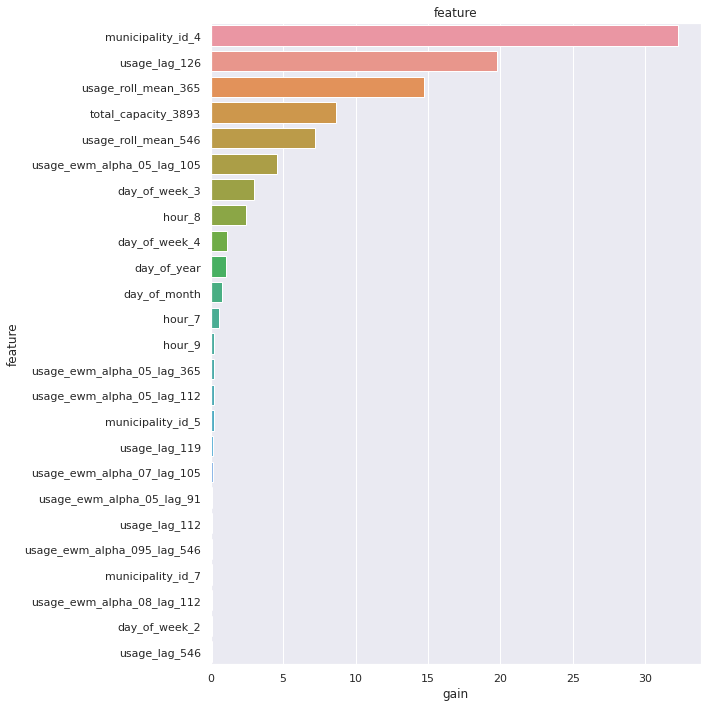

,feature,split,gain
68,municipality_id_4,113,32.245204
12,usage_lag_126,660,19.739003
17,usage_roll_mean_365,342,14.702576
83,total_capacity_3893,29,8.645950
18,usage_roll_mean_546,323,7.238066
57,usage_ewm_alpha_05_lag_105,195,4.576163
87,day_of_week_3,306,3.007688
92,hour_8,227,2.421278
88,day_of_week_4,146,1.126109
2,day_of_year,326,1.087463


In [95]:
plot_lgb_importances(model, num=200)

plot_lgb_importances(model, num=30, plot=True)

In [96]:
feat_imp = plot_lgb_importances(model, num=200)

                         feature  split       gain
68             municipality_id_4    113  32.245204
12                 usage_lag_126    660  19.739003
17           usage_roll_mean_365    342  14.702576
83           total_capacity_3893     29   8.645950
18           usage_roll_mean_546    323   7.238066
57    usage_ewm_alpha_05_lag_105    195   4.576163
87                 day_of_week_3    306   3.007688
92                        hour_8    227   2.421278
88                 day_of_week_4    146   1.126109
2                    day_of_year    326   1.087463
1                   day_of_month    445   0.782930
91                        hour_7    170   0.586725
93                        hour_9    117   0.260295
61    usage_ewm_alpha_05_lag_365     76   0.251948
58    usage_ewm_alpha_05_lag_112    100   0.251690
69             municipality_id_5     67   0.211634
11                 usage_lag_119    141   0.139883
48    usage_ewm_alpha_07_lag_105     20   0.134432
55     usage_ewm_alpha_05_lag_9

In [97]:
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

In [98]:
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

100

# Final Model

In [99]:
train = df.loc[(df["timestamp"] <"2017-08-05"),:]
Y_train = train['usage']
X_train = train[cols]

test = df.loc[(df["timestamp"] >="2017-08-05"),:]
X_test = test[cols]

In [100]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005434 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [101]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [102]:
test.head()

,timestamp,usage,month,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,usage_lag_91,usage_lag_98,usage_lag_105,usage_lag_112,usage_lag_119,usage_lag_126,usage_lag_182,usage_lag_364,usage_lag_546,usage_lag_728,usage_roll_mean_365,usage_roll_mean_546,usage_ewm_alpha_095_lag_91,usage_ewm_alpha_095_lag_98,usage_ewm_alpha_095_lag_105,usage_ewm_alpha_095_lag_112,usage_ewm_alpha_095_lag_180,usage_ewm_alpha_095_lag_270,usage_ewm_alpha_095_lag_365,usage_ewm_alpha_095_lag_546,usage_ewm_alpha_095_lag_728,usage_ewm_alpha_09_lag_91,usage_ewm_alpha_09_lag_98,usage_ewm_alpha_09_lag_105,usage_ewm_alpha_09_lag_112,usage_ewm_alpha_09_lag_180,usage_ewm_alpha_09_lag_270,usage_ewm_alpha_09_lag_365,usage_ewm_alpha_09_lag_546,usage_ewm_alpha_09_lag_728,usage_ewm_alpha_08_lag_91,usage_ewm_alpha_08_lag_98,usage_ewm_alpha_08_lag_105,usage_ewm_alpha_08_lag_112,usage_ewm_alpha_08_lag_180,usage_ewm_alpha_08_lag_270,usage_ewm_alpha_08_lag_365,usage_ewm_alpha_08_lag_546,usage_ewm_alpha_08_lag_728,usage_ewm_alpha_07_lag_91,usage_ewm_alpha_07_lag_98,usage_ewm_alpha_07_lag_105,usage_ewm_alpha_07_lag_112,usage_ewm_alpha_07_lag_180,usage_ewm_alpha_07_lag_270,usage_ewm_alpha_07_lag_365,usage_ewm_alpha_07_lag_546,usage_ewm_alpha_07_lag_728,usage_ewm_alpha_05_lag_91,usage_ewm_alpha_05_lag_98,usage_ewm_alpha_05_lag_105,usage_ewm_alpha_05_lag_112,usage_ewm_alpha_05_lag_180,usage_ewm_alpha_05_lag_270,usage_ewm_alpha_05_lag_365,usage_ewm_alpha_05_lag_546,usage_ewm_alpha_05_lag_728,municipality_id_0,municipality_id_1,municipality_id_2,municipality_id_3,municipality_id_4,municipality_id_5,municipality_id_6,municipality_id_7,municipality_id_8,municipality_id_9,total_capacity_397,total_capacity_587,total_capacity_697,total_capacity_1332,total_capacity_1930,total_capacity_2019,total_capacity_2813,total_capacity_2947,total_capacity_3113,total_capacity_3893,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16
10398,2017-08-05 08:00:00,209,8,5,217,31,2017,1,0,0,1056.935540,1006.174685,218.218821,696.359700,597.364326,180.274408,572.260534,519.145648,563.636873,248.569861,562.150185,515.573551,1056.357114,997.178213,217.213229,694.365420,470.878889,528.758969,510.762122,563.543066,247.072449,1057.937807,987.758573,215.395526,693.653641,474.932345,530.743595,509.334652,563.062898,243.878488,1061.833967,966.691332,212.274841,691.950815,483.681601,535.460847,505.790655,561.951407,236.628780,1066.800864,941.552026,211.710094,689.779709,493.542261,541.365694,500.981534,560.403895,228.271644,1078.660091,869.491688,232.936068,682.816728,518.377542,558.235626,483.720786,553.229868,212.369559,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
10407,2017-08-05 08:00:00,252,8,5,217,31,2017,1,0,0,227.338426,1113.401208,271.981505,704.218196,632.785867,225.843268,542.300754,525.372884,547.173991,360.237571,561.400513,512.689887,269.417856,1107.208911,269.260661,704.468271,309.493944,478.637948,516.688106,546.877153,352.453622,310.993781,1100.475857,266.339553,703.865364,318.393234,481.474360,516.233465,547.706290,346.587849,394.766793,1083.738266,260.054968,702.390163,337.536320,487.892169,514.758131,549.190281,333.725756,479.640259,1061.565608,253.913028,700.433913,358.762678,495.609708,512.194460,550.321169,319.081493,653.330046,991.245844,252.468034,693.908364,409.688771,517.117813,500.360393,549.614934,285.184780,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
10416,2017-08-05 09:00:00,322,8,5,217,31,2017,1,0,0,289.482715,1163.183168,372.054449,739.821571,647.744242,285.140215,469.591720,513.085083,559.709179,417.831820,562.414509,513.782092,290.870893,1160.210446,367.813033,736.323414,365.074697,219.631897,524.584405,558.393858,414.722681,293.899378,1156.747586,362.333955,734.586536,363.039323,233.547436,524.123347,557.870629,410.858785,312.553359,1147.147653,350.410994,730.878033,361.90

In [103]:
result_df = test.loc[:, ["timestamp", "usage", "municipality_id_6"]]
result_df["usage"] = test_preds

In [104]:
result_df[result_df.municipality_id_6==1].shape

(268, 3)

In [105]:
df_6_pred = result_df[result_df.municipality_id_6==1].loc[:,["timestamp", "usage"]].reset_index(drop=True)

In [106]:
df_6_pred.head()

,timestamp,usage
0,2017-08-05 08:00:00,507.330837
1,2017-08-05 08:00:00,579.591652
2,2017-08-05 09:00:00,735.371436
3,2017-08-05 09:00:00,810.480838
4,2017-08-05 10:00:00,866.137022


In [107]:
df_6_test= test.loc[test.municipality_id_6==1,["timestamp","usage"]].reset_index(drop=True)

In [108]:
df_6_test.head()

,timestamp,usage
0,2017-08-05 08:00:00,494
1,2017-08-05 08:00:00,571
2,2017-08-05 09:00:00,666
3,2017-08-05 09:00:00,755
4,2017-08-05 10:00:00,857


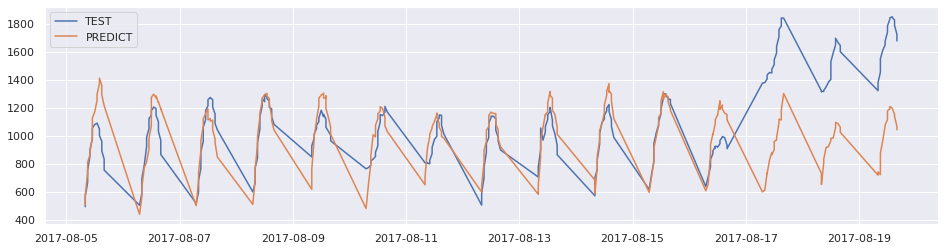

In [109]:
plt.figure(figsize=(16,4))
plt.plot(df_6_test.timestamp,df_6_test.usage,label="TEST")
plt.plot(df_6_pred.timestamp,df_6_pred.usage, label="PREDICT")
plt.legend()
plt.show()